In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys, re, shutil
from pathlib import Path
import copy

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

import os
import multiprocessing as mp
import pandas as pd
import pyarrow.parquet as pq
import xarray as xr
from gempyor import config, model_info, outcomes, seir, inference_parameter, logloss, inference

import os
from multiprocessing import cpu_count

# disable  operations using the MKL linear algebra.
os.environ["OMP_NUM_THREADS"] = "1"
import emcee

from multiprocessing import Pool

config_path = f"simple_usa_statelevel.yml"
seir_modifiers_scenario="Ro_all"
outcome_modifiers_scenario=None

nwalkers = 22
#config_path = f"config_CACOMD_maternal_v8_emcee.yml"
#nwalkers = 128
niter = 50
nsamples = 50 # number of likelyhood eval to write to disk...
thin=5

ncpu = cpu_count()
print(f"found {ncpu} CPUs, using these")
config.clear()
config.read(user=False)
config.set_file(config_path)
# same but in a Path safe way
config.set_file
print(config_path)


run_id = config_path.split(".")[0]

in_run_id = run_id
out_run_id = in_run_id
in_prefix = f"emcee_{run_id}"
out_prefix = in_prefix

write_csv = False
write_parquet = True

modinf = model_info.ModelInfo(
    config=config,
    nslots=1,
    seir_modifiers_scenario=seir_modifiers_scenario,
    outcome_modifiers_scenario=outcome_modifiers_scenario,
    write_csv=write_csv,
    write_parquet=write_parquet,
    first_sim_index=1,
    in_run_id=in_run_id,
    in_prefix=in_prefix,
    inference_filename_prefix="no",
    inference_filepath_suffix="no",
    out_run_id=out_run_id,
    out_prefix=out_prefix,
    stoch_traj_flag=False,
)

nsubpop = len(modinf.subpop_struct.subpop_names)
subpop_names = modinf.subpop_struct.subpop_names

inferpar = inference_parameter.InferenceParameters(global_config=config, modinf=modinf)
p0 = inferpar.draw_initial(n_draw=nwalkers)
for i in range(nwalkers):
    assert inferpar.check_in_bound(proposal=p0[i]), "The initial parameter draw is not within the bounds, check the perturbation distributions"


static_sim_arguments = gempyor.inference.get_static_arguments(modinf=modinf)

print(inferpar)


INFO:root:Running ModelInfo with outcomes but without Outcomes Modifiers
INFO:root:[SEIR.compartments] completed in 0.01 s
INFO:root:[Outcome.structure] completed in 0.00 s
INFO:root:[SEIR.NPI] completed in 0.01 s


found 12 CPUs, using these
simple_usa_statelevel.yml
InferenceParameters: with 102 parameters: 
    seir_modifiers: 102 parameters



## Generate a ground-truth (do once)
There is already a ground-truth data generated on git, but if you want to make yours, first run:
```bash
gempyor-simulate -c simple_usa_statelevel.yml -n 1
```
then execute the following code ... or do as follow:
```python
gt=gempyor.read_df("model_output/USA_influpaint_Ro_all/20240411_193531/hosp/000000001.20240411_193531.hosp.parquet")
gt=gt.drop("time", axis=1).set_index("date")
gt[gt["subpop"]=="56000"].plot();
gempyor.write_df(fname = "model_input/data/generated_gt_data.csv", df=gt)
```

In [4]:
p_gt = inferpar.draw_initial(n_draw=1)[0]
np.save("parameter_ground_truth.npy", p_gt)

INFO:root:[SEIR.NPI] completed in 0.01 s
INFO:root:Integrating with method rk4.jit
183it [00:05, 33.40it/s]


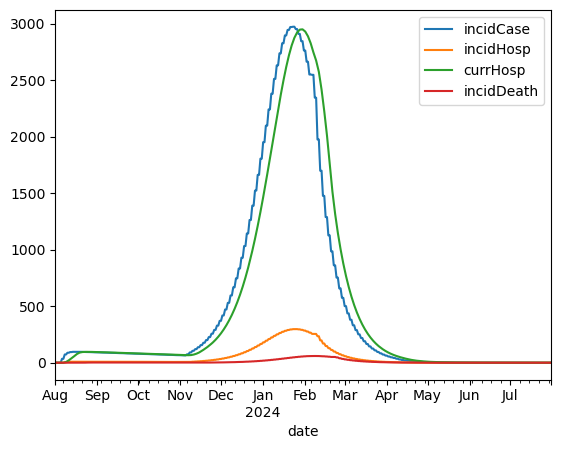

In [5]:
# run with the gt
snpi_df_mod, hnpi_df_mod = inferpar.inject_proposal(proposal=p_gt, snpi_df = static_sim_arguments["snpi_df_ref"], hnpi_df = static_sim_arguments["hnpi_df_ref"])
    
ss = copy.deepcopy(static_sim_arguments)
ss["snpi_df_in"] = snpi_df_mod
ss["hnpi_df_in"] = hnpi_df_mod
del ss["snpi_df_ref"]
del ss["hnpi_df_ref"]

    
gt_df = gempyor.inference.simulation_atomic(**ss, modinf=modinf, save=False)
gt_df[gt_df["subpop"]=="56000"].plot();

In [6]:
gempyor.write_df(fname = "model_input/data/generated_gt_data.csv", df=gt_df.reset_index())

## Run EMCEE

In [4]:
loss = logloss.LogLoss(inference_config=config["inference"], modinf=modinf)
print(loss)

LogLoss: 3 statistics and 18666 data points,number of NA for each statistic: 
incidCase     0
incidHosp     0
currHosp      0
incidDeath    0
dtype: int64


In [ ]:
filename = f"{run_id}_backend.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, inferpar.get_dim())
args = {"modinf":modinf,
        "inferpar":inferpar,
        "loss":loss,
        "static_sim_arguments":static_sim_arguments,
        "save":False}
with Pool(ncpu) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, 
                                    inferpar.get_dim(), 
                                    gempyor.inference.emcee_logprob,
                                    args=[modinf, inferpar, loss, static_sim_arguments], 
                                    pool=pool,
                                    backend=backend, moves=[(emcee.moves.StretchMove(live_dangerously=True), 1)])
    state = sampler.run_mcmc(p0, niter, progress=True, skip_initial_state_check=True)
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    ))

# Analysis

In [8]:
sampler = emcee.backends.HDFBackend(filename, read_only=True)
sampler.get_chain().shape

last_llik = sampler.get_log_prob()[-1,:]
good_slots = last_llik > (last_llik.mean()-1*last_llik.std())
print(f"there are {good_slots.sum()}/{len(good_slots)} good walkers... keeping these")

there are 18/22 good walkers... keeping these


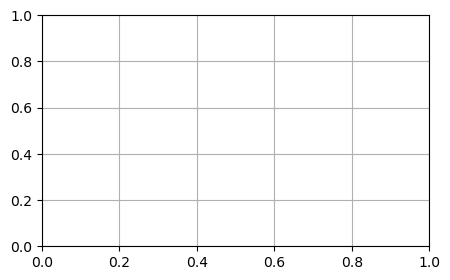

In [9]:
df_l = []
for fn in  gempyor.utils.list_filenames(folder="synthetic_dataset/model_output/", filters=["hosp", ".parquet"]):
    df_l.append(gempyor.read_df(fn))
fig, axes = plt.subplots(1,1, figsize=(5,3))
ax = axes
for df in df_l:
    ax.plot(df.drop("time",axis=1).set_index("date").groupby("date").sum()["incidCase"], lw=.5)
ax.grid()

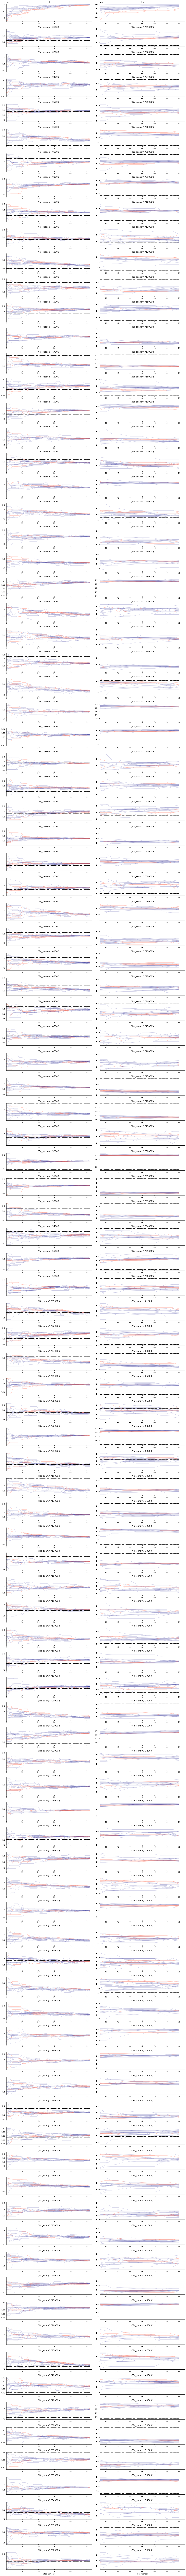

In [13]:
fig, axes = plt.subplots(inferpar.get_dim()+1,2, figsize=(15, (inferpar.get_dim()+1)*2))

labels = list(zip(inferpar.pnames, inferpar.subpops))
samples = sampler.get_chain()
p_gt = np.load("parameter_ground_truth.npy")

import seaborn as sns
def plot_chain(frompt,axes):
    ax = axes[0]

    ax.plot(np.arange(frompt,frompt+sampler.get_log_prob()[frompt:].shape[0]),
                      sampler.get_log_prob()[frompt:,good_slots], "navy", alpha=.2, lw=1, label="good walkers")
    ax.plot(np.arange(frompt,frompt+sampler.get_log_prob()[frompt:].shape[0]),
            sampler.get_log_prob()[frompt:,~good_slots], "tomato", alpha=.4, lw=1, label="bad walkers")
    ax.set_title("llik")
    #ax.legend()
    sns.despine(ax=ax, trim=False)
    ax.set_xlim(frompt, frompt+sampler.get_log_prob()[frompt:].shape[0])

    #ax.set_xlim(0, len(samples))

    for i in range(inferpar.get_dim()):
        ax = axes[i+1]
        x_plt = np.arange(frompt,frompt+sampler.get_log_prob()[frompt:].shape[0])
        ax.plot(x_plt,
                samples[frompt:,good_slots, i], "navy", alpha=.2, lw=1,)
        ax.plot(x_plt,
                samples[frompt:, ~good_slots, i], "tomato", alpha=.4, lw=1,)
        ax.plot(x_plt,
                np.repeat(p_gt[i],len(x_plt)), "black", alpha=1, lw=2, ls='-.')
        #ax.set_xlim(0, len(samples))
        ax.set_title(labels[i])
        #ax.yaxis.set_label_coords(-0.1, 0.5)
        sns.despine(ax=ax, trim=False)
        ax.set_xlim(frompt, frompt+samples[frompt:].shape[0])
        

    axes[-1].set_xlabel("step number");

plot_chain(0,axes[:,0])
plot_chain(3*samples.shape[0]//4,axes[:,1])
fig.tight_layout()

plt.savefig(f"{run_id}_chains.pdf")

In [14]:
good_samples =  sampler.get_chain()[:,good_slots,:]
good_samples.shape

step_number = -1
exported_samples = np.empty((nsamples,inferpar.get_dim()))
for i in range(nsamples):
    exported_samples[i,:] = good_samples[step_number - thin*(i//(good_slots.sum())) ,i%(good_slots.sum()),:] # parentesis around i//(good_slots.sum() are very important

In [18]:
exported_samples.shape

(50, 102)

In [ ]:
position_arguments = [modinf, inferpar, loss, static_sim_arguments, True]
shutil.rmtree("model_output/")
with Pool(ncpu) as pool:
    results = pool.starmap(gempyor.inference.emcee_logprob, [(sample, *position_arguments) for sample in exported_samples])


In [25]:
gt_s[stat.data_var]

Series([], Freq: W-SAT, Name: incidDeath, dtype: float64)

In [28]:
loss.gt

subpop   incidCase  incidHosp    currHosp  incidDeath
date                                                             
2023-08-01   56000    0.000000   0.000000    0.000000    0.000000
2023-08-02   56000    0.000000   0.000000    0.000000    0.000000
2023-08-03   56000    0.000000   0.000000    0.000000    0.000000
2023-08-04   56000    0.000000   0.000000    0.000000    0.000000
2023-08-05   56000    0.000000   0.000000    0.000000    0.000000
...            ...         ...        ...         ...         ...
2024-07-27    6000  434.010294  44.627490  478.851565   10.843307
2024-07-28    6000  434.010294  44.627490  472.191034   10.843307
2024-07-29    6000  422.076746  43.401029  465.709699   10.546481
2024-07-30    6000  422.076746  43.401029  459.228364   10.546481
2024-07-31    6000  410.465646  42.207675  452.921598   10.257604

[18666 rows x 5 columns]

In [29]:
subpop

'06000'

In [27]:
gt_s = loss.gt[loss.gt["subpop"]==subpop].sort_index()
gt_s

Empty DataFrame
Columns: [subpop, incidCase, incidHosp, currHosp, incidDeath]
Index: []

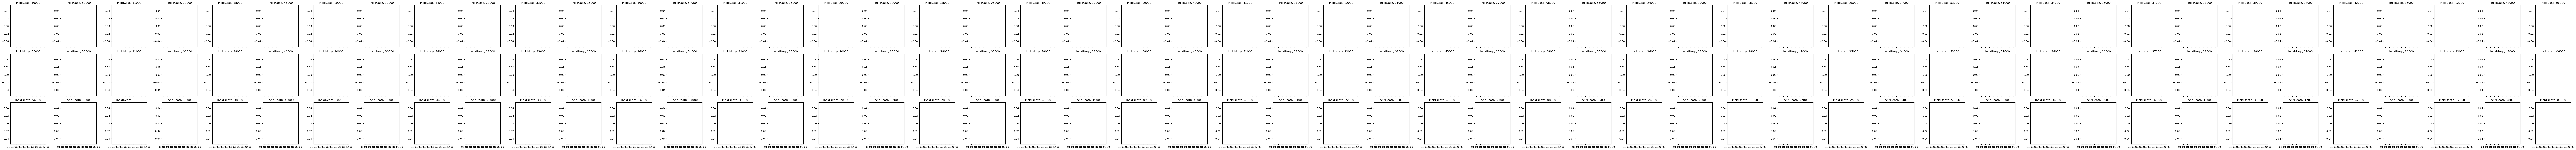

In [24]:

results = []
for fn in gempyor.utils.list_filenames(folder="model_output/", filters=[run_id,"hosp.parquet"]):
        df = gempyor.read_df(fn)
        df = df.set_index("date")
        results.append(df)

fig, axes = plt.subplots(len(subpop_names),len(loss.statistics), figsize=(3*len(loss.statistics), 3*len(subpop_names)), sharex=True)
for j, subpop in enumerate(modinf.subpop_struct.subpop_names):
        gt_s = loss.gt[loss.gt["subpop"]==subpop].sort_index()
        first_date = max(gt_s.index.min(),results[0].index.min())
        last_date = min(gt_s.index.max(), results[0].index.max())
        gt_s = gt_s.loc[first_date:last_date].drop(["subpop"],axis=1).resample("W-SAT").sum()
        
        for i, (stat_name, stat) in enumerate(loss.statistics.items()):
                ax = axes[j,i]
                
                ax.plot(gt_s[stat.data_var], color='k', marker='.', lw=1)
                for model_df in results:
                        model_df_s = model_df[model_df["subpop"]==subpop].drop(["subpop"],axis=1).loc[first_date:last_date].resample("W-SAT").sum() # todo sub subpop here
                        ax.plot(model_df_s[stat.sim_var],  lw=.9, alpha=.5)
                #if True:
                #        init_df_s = outcomes_df_ref[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                ax.set_title(f"{stat_name}, {subpop}")
fig.tight_layout()
plt.savefig(f"{run_id}_results.pdf")


## Generate some tests for logprob

In [2]:
from gempyor import statistics

statistics(co)

AttributeError: module 'gempyor.statistics' has no attribute 'plot_poisson_pmf'